In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

# Homework on Novelty Detection

----------------------------------------------------
Machine Learning                      

*Emilio Parrado Hernández, eparrado@ing.uc3m.es*

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es*

----------------------------------------------------

In this practice you will analyze the use of novelty detection in a classification problem using the database of face recognition introduced in these past lectures.

To solve this notebook, complete the following sections implementing the solution that you consider most appropriate and showing the results that you find most interesting.


## 1. Data loading and preprocessing

The following cell reproduces part of the code we used to download and plot some of the images during the lecture. Feel free to use as it is.


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

def plot_gallery(images, titles, h, w, n_row=4, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.colorbar()
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
print('The first time that you download the data it can take a while...')
olivetti_people = fetch_olivetti_faces()

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = olivetti_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = olivetti_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
Y = olivetti_people.target
class_names = np.unique(Y)
n_classes = class_names.shape[0]

print("Dataset size information:")
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# As example, we plot a face of each class (or person)
titles = ['cl '+str(c)+","+str(ic) for ic,c in enumerate(Y)]
ind_faces = [np.where(Y == c)[0][0] for c in class_names]

plot_gallery(X[:,:], titles, h, w, n_row=40)

Output hidden; open in https://colab.research.google.com to view.

# 2. Definition of the novelty detection tasks

We are starting with a multiclass classification problem but only **with images of subjects that don't wear glasses nor beard/moustache**. For this purpose, the following cell constructs some arrays that will help us simulate the novelty detection scenarios:
- `glasses_images`: all the images with glasses in the dataset
- `beard_moustache_images`: all the images with beard and/or moustache
- `inlier_class_images`: all the images without glasses and without beard/moustache

In [ ]:
# classes of subjects that wear beard and/or moustache
beard_moustache_class = [6, 10, 13, 15, 16, 24, 25, 27, 36]
# images with beard and/or moustache
beard_moustache_images = [ic for ic,cc in enumerate(Y) if cc in beard_moustache_class]

# classes of subjects that wear glasses in all the pictures
all_glasses_class = [1, 5, 13, 26, 27, 30, 33, 36]

# classes of subjects that wear glasses in some of the pictures
some_glasses_class = [3, 6, 12, 16, 18, 19, 35]

# classes of subjects that wear glasses or beard or moustache in some of the pictures
outlier_class = all_glasses_class + some_glasses_class
outlier_class += [cc for cc in beard_moustache_class if cc not in all_glasses_class + some_glasses_class]

# classes of subjects without beard, moustache and glasses in all the pictures
inlier_class = [cc for cc in range(40) if cc not in outlier_class]
inlier_class_images = [ic for ic,cc in enumerate(Y) if cc in inlier_class]

# images with glasses
glasses_images = [ic for ic,cc in enumerate(Y) if cc in all_glasses_class]
glasses_images += [30, 31, 32, 37, 38,
                63, 64, 69,
                120, 121, 124, 125, 126, 127, 128, 129,
                160, 161, 164, 165, 166, 167, 168, 169,
                180, 181, 182, 185, 189,
                190, 191, 192, 194, 196, 197, 198, 199,
                358, 359]
print("Found {0:d} images with beard/moustache".format(len(beard_moustache_images)))
print("Found {0:d} images with glasses".format(len(glasses_images)))


Found 90 images with beard/moustache
Found 119 images with glasses


In [ ]:
titles = ['image '+str(ic) for ic in glasses_images]
ind_faces = glasses_images

plot_gallery(X[ind_faces,:], titles, h, w, n_row=12)

Output hidden; open in https://colab.research.google.com to view.

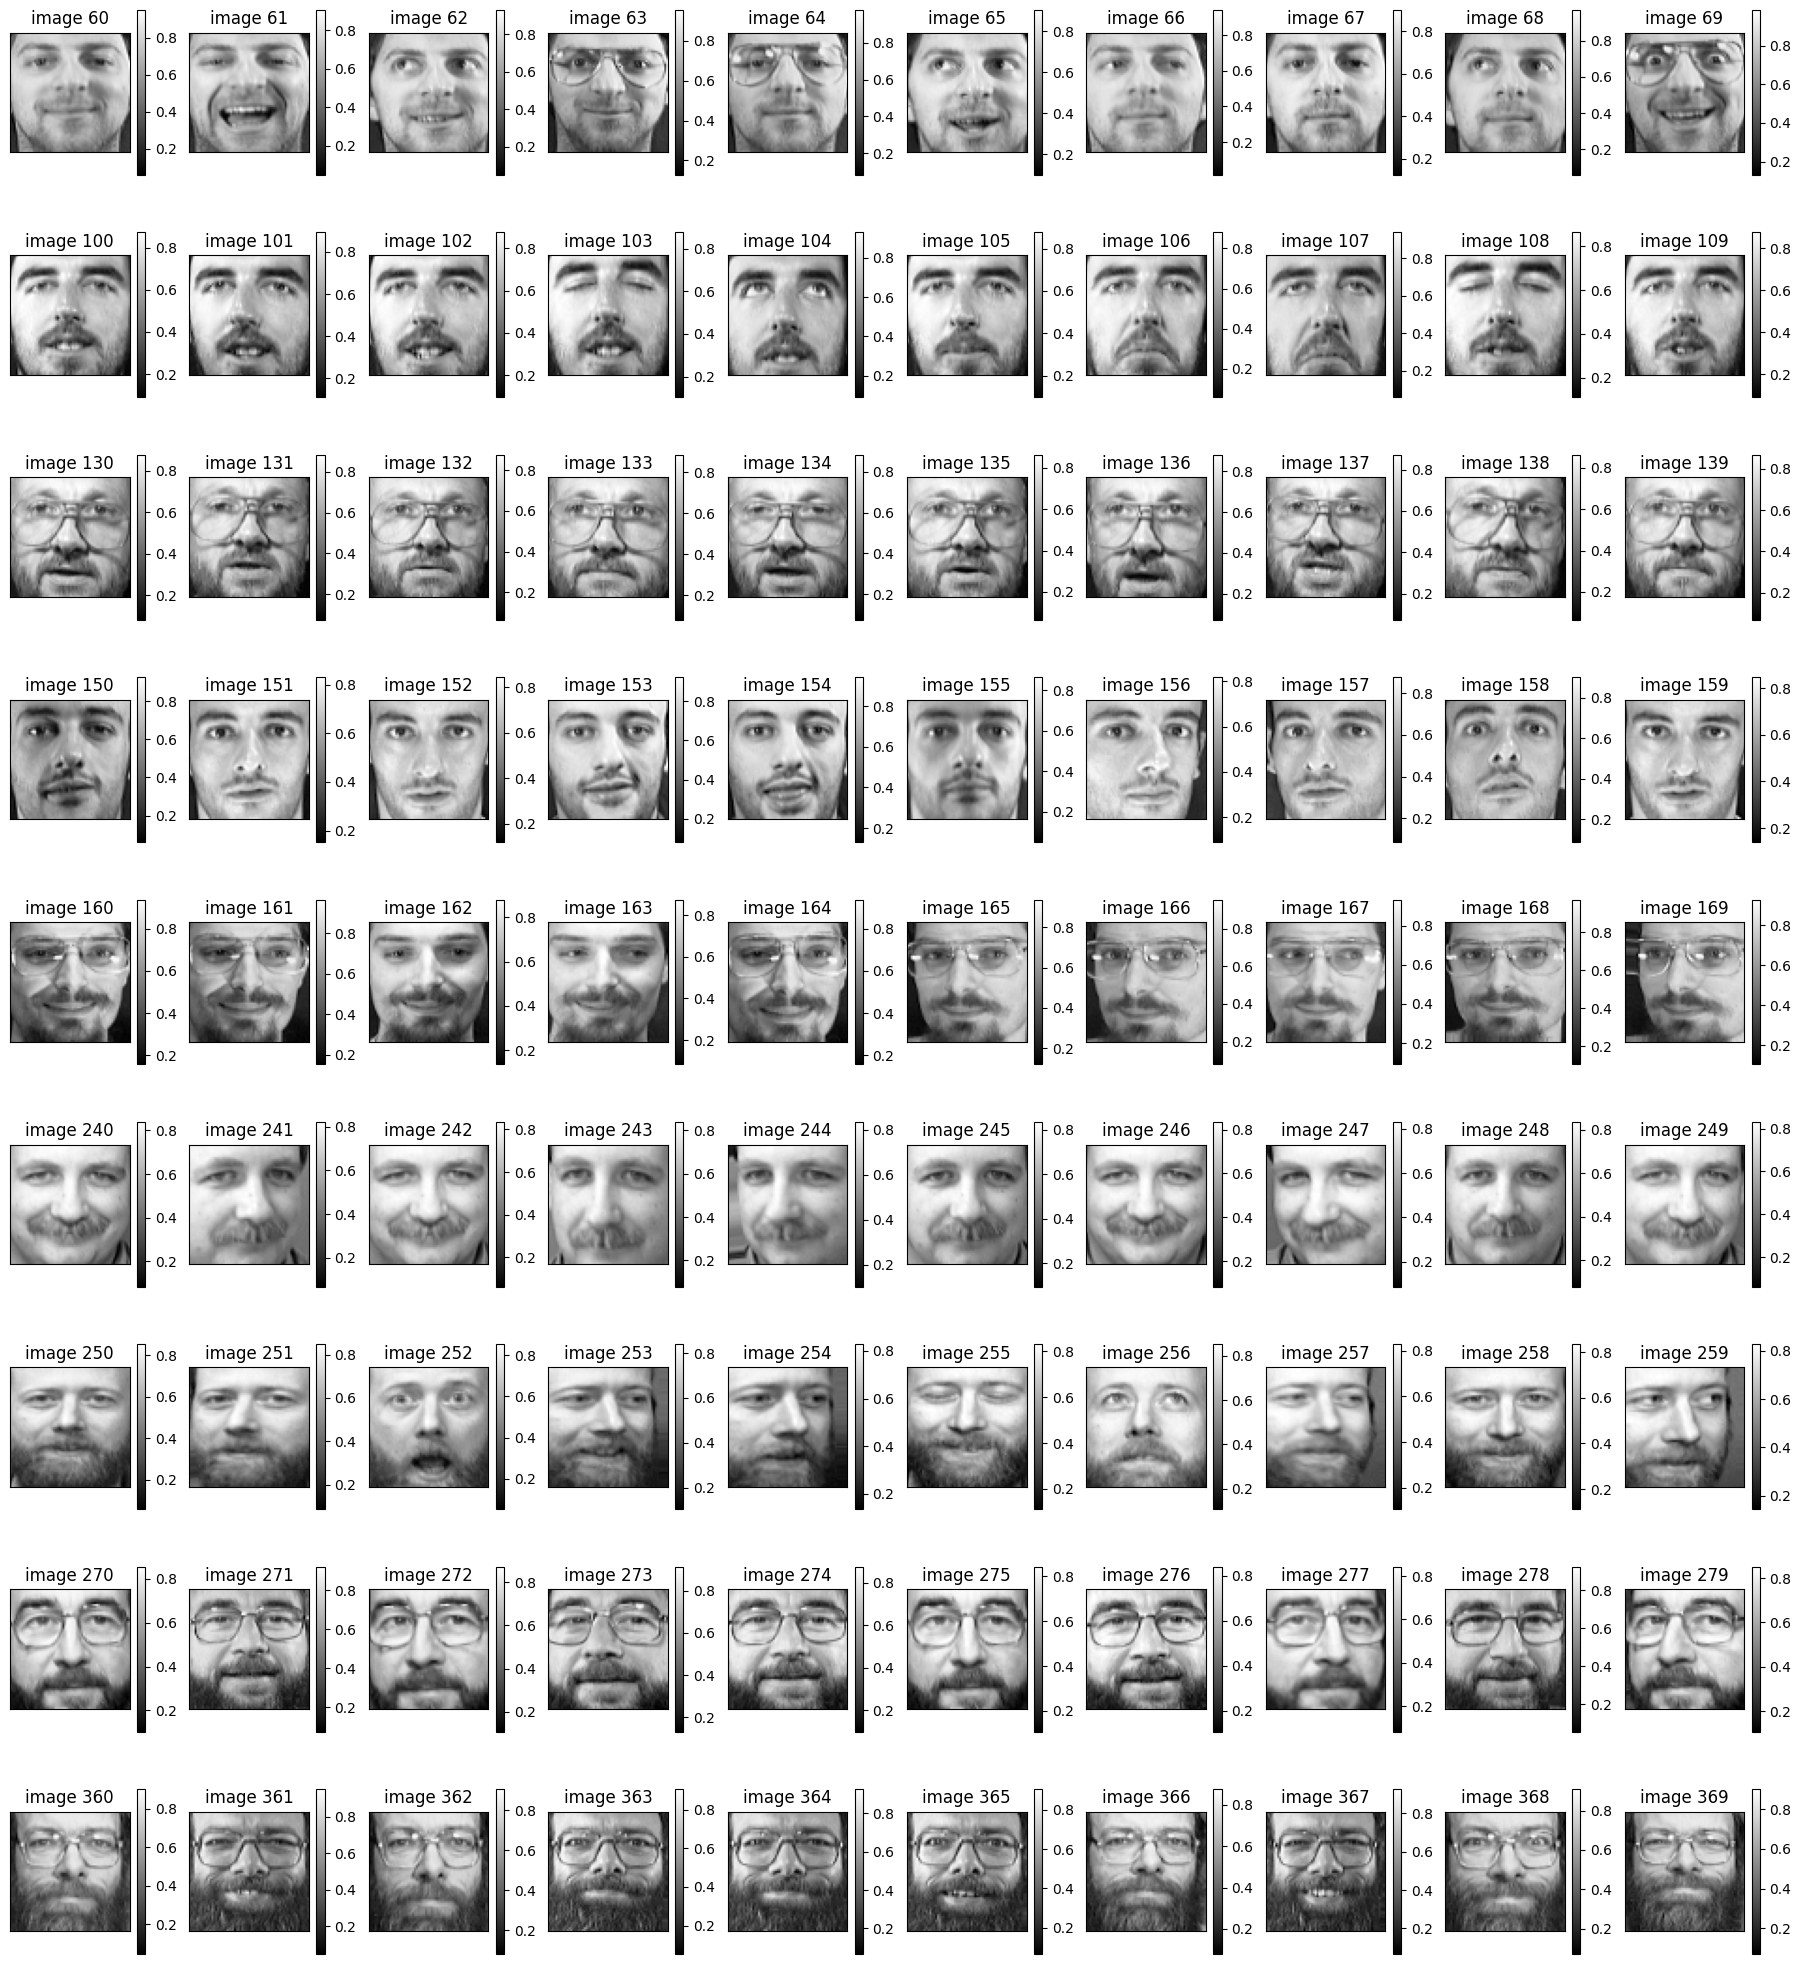

In [ ]:
titles = ['image '+str(ic) for ic in beard_moustache_images]
ind_faces = beard_moustache_images

plot_gallery(X[ind_faces,:], titles, h, w, n_row=9)

# 3. Simulate the classification task without novelty

The first step is to create a classification scenario only with those images of subjects that wear no glasses nor beard. For this purpose write code that
- Store all the images contained in the list `inlier_class_images` in a numpy array called `X_inlier`.
- Store the true targets of the images contained in the list `inlier_class_images` in a numpy array called `Y_inlier`.
- Split these images in a 80/20 training/testing partition and store these partitions in arrays `X_inlier_train`, `X_inlier_test`, `Y_inlier_train` and `Y_inlier_test`


In [ ]:
############
# YOUR CODE

from sklearn.model_selection import train_test_split
X_inlier =  X[inlier_class_images, :]
Y_inlier =  Y[inlier_class_images]
X_inlier_train, X_inlier_test, Y_inlier_train, Y_inlier_test = train_test_split(X_inlier,
                                                                                Y_inlier,
                                                                                test_size=0.2)
############
print("Size of the training set {0:d}".format(X_inlier_train.shape[0]))
print("Size of the test set {0:d}".format(X_inlier_test.shape[0]))

Size of the training set 168
Size of the test set 42


## 3.1. First classification method: SVM

The first classification method is a SVM acting directly on the raw images. Find the best classifier using cross-validation to choose between a linear and a RBF kernel (also use cross validation to tune $C$ and the kernel parameters).

Print the best parameters found for this classifier and its classification accuracy estimated with cross validation (that is, the crossvalidation accuracy achieved by the best set of hyperparameters).

In [ ]:
############
# YOUR CODE

from sklearn import svm
from sklearn.model_selection import GridSearchCV

v_C = [100, 1000, 1e4, 1e5]
v_gamma = [1e-6, 1e-5, 1e-4, 1e-3]

parameters_svm = [{'C':v_C,
             'gamma':v_gamma,
             'kernel':['rbf']},
              {'C':v_C,
             'kernel':['linear']}]
grid_svm = GridSearchCV(svm.SVC(), parameters_svm)
grid_svm.fit(X_inlier_train, Y_inlier_train)
print("Best parameters SVM")
print(grid_svm.best_params_)
print("Best XV score SVM")
print(grid_svm.best_score_)

############


Best parameters SVM
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best XV score SVM
0.970409982174688


### Test error of the SVM with the inlier data

Now use the SVM with its best hyperparameter configuration to compute the accuracy in the test data of the inlier classes (`X_inlier_test` and `Y_inlier_test`):

In [ ]:
############
# YOUR CODE

acc_test_inliers_svm = 100.*grid_svm.score(X_inlier_test, Y_inlier_test)
print("Test accuracy, just inlier classes: {0:.2f}".format(acc_test_inliers_svm))

############


Test accuracy, just inlier classes: 83.33


## 3.2. Second Classification method: PCA + SVM

The second classification method is a pipeline with three steps:
1. Standard Scaler of the data
2. PCA with a number of components between 5 and 100 to be determined using cross-validation
3. SVM with linear kernel

Find the best pipeline using cross-validation to optimize the best configuration of the pipeline:
- Number of principal components
- Parameter $C$ of the SVM

Print the best parameters found for this classifier (Number of components of the PCA and SVM configuration) and its classification accuracy estimated with cross validation (that is, the crossvalidation accuracy achieved by the best set of hyperparameters).

In [ ]:
############
# YOUR CODE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


v_C = [1, 10, 100, 1000, 1e4, 1e5]
v_gamma = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]


list_PCA = [PCA(n_components=cc) for cc in range(5,101,20)]
sc_pca_svm = Pipeline([('scaler',StandardScaler()),
                       ('pca', PCA()),
                      ('svm', svm.SVC(kernel='rbf'))])
parameters_sc_pca_svm = {'pca':list_PCA, 'svm__C':v_C, 'svm__gamma':v_gamma}

grid_sc_pca_svm = GridSearchCV(sc_pca_svm, parameters_sc_pca_svm)

grid_sc_pca_svm.fit(X_inlier_train, Y_inlier_train)
print("Best parameters PCA+SVM")
print(grid_sc_pca_svm.best_params_)
print("Best XV score PCA+SVM")
print(grid_sc_pca_svm.best_score_)
############

Best parameters PCA+SVM
{'pca': PCA(n_components=45), 'svm__C': 1000, 'svm__gamma': 0.0001}
Best XV score PCA+SVM
0.9764705882352942


### Test error of the PCA+SVM with the inlier data

Now use the PCA+SVM with its best hyperparameter configuration to compute the accuracy in the test data of the inlier classes:

In [ ]:
############
# YOUR CODE

acc_test_inliers_pca_svm = 100.*grid_sc_pca_svm.score(X_inlier_test, Y_inlier_test)
print("Test accuracy, just inlier classes: {0:.2f}".format(acc_test_inliers_pca_svm))

############

Test accuracy, just inlier classes: 80.95


## 3.3. Discussion

Comment on the different test accuracies of the two classification methods. Do you think these classification tasks are easy to solve with machine learning?

# 4. Degradation in performance due to novelties

Now you are going to introduce elements of the outlier classes in the **test set** and measure the effect in the performance of the algorithm.  The simulation basically consists in:
- create a new test set merging the images in `X_inlier_test` and the outliers determined in each case. Notice **there will be labels in the test set that were not in the training set**. Name `my_Xtest` and `my_Ytest` the resulting arrays with the images and the targets, respectively.



## 4.1. Degradation as images with beard appear

In this section `my_Xtest` and `my_Ytest` will incorporate images of subjects with beard/moustache. Write the code that generates these two arrays.

In [ ]:
############
# YOUR CODE

raros = beard_moustache_images[:]
my_Xtest = np.vstack((X_inlier_test, X[raros,:]))
my_Ytest = np.hstack((Y_inlier_test, Y[raros]))
############

The next variable is a list of dicitionaries to store partial results to carry out a final analysis of the results

In [ ]:
overall_results_list_dd = []

### 4.1.1. Impact on SVM

Now you will simulate the novelties in the test set impact in the performance of the first classifier. Since those novel images belong to classes not present during training, it is adviced to use [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for a systematic collection of the multiclass errors.

Write code that predicts the merged test set (`my_Xtest`) and using these predictions and the true labels in `my_Ytest` fill a dictionary with the following keys:
- `method`: a tag for describing the classifier, for instance "SVC"
- `hits`: number of elements in the test set correctly assigned to its true class
- `inlier errors`: number of elements in the test set whose true class was present in the training set, but have been incorrectly assigned by the classifier to a wrong class
- `outlier errors`: number of outliers in the test set incorrectly assigned

Append this dictionary to `overall_results_list_dd`

#### Some hints for the analysis of the results:
**Print the number of hits and the number of the two sources of error for every individual class in the training set, to check if all the classes are equally contaminated by the outliers or not.**

**Additionally you can plot examples of the photos of the true class and of some of the outliers assigned to that class to discuss any possible interpretability of the outcome.**

In [ ]:
############
# YOUR CODE
from sklearn.metrics import confusion_matrix

def simulate(estimator, tag, my_Xtest, my_Ytest):
    predict = estimator.predict(my_Xtest)
    CF = pd.DataFrame(confusion_matrix(my_Ytest, predict, labels=range(40)),
                      index=range(40),
                      columns=range(40))
    dd = {'method':tag,
     'hits':0,
      'inlier errors':0,
      'outlier errors':0}

    all_assigned = CF.sum(0)
    for user in inlier_class:
        assigned = all_assigned.loc[user]
        own_images = CF.loc[user, user]
        inliers = CF.loc[inlier_class, user].sum() - own_images
        outliers = assigned - inliers - own_images
        print("User {0:d}: Own: {1:d} Inlier errors: {2:d} Outliers: {3:d}".format(user,
                                                     own_images,
                                                    inliers,
                                                    outliers))
        dd['hits'] += own_images
        dd['inlier errors'] += inliers
        dd['outlier errors'] += outliers
    return dd

overall_results_list_dd.append(simulate(grid_svm, 'SVM', my_Xtest, my_Ytest))
############

User 0: Own: 1 Inlier errors: 2 Outliers: 6
User 2: Own: 0 Inlier errors: 0 Outliers: 35
User 4: Own: 2 Inlier errors: 1 Outliers: 1
User 7: Own: 4 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 1
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 1 Inlier errors: 0 Outliers: 1
User 14: Own: 3 Inlier errors: 0 Outliers: 5
User 17: Own: 2 Inlier errors: 0 Outliers: 3
User 20: Own: 4 Inlier errors: 0 Outliers: 1
User 21: Own: 2 Inlier errors: 0 Outliers: 1
User 22: Own: 0 Inlier errors: 0 Outliers: 16
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 11
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 2 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 3 Inlier errors: 1 Outliers: 1
User 39: Own: 0 Inlier errors: 2 Outliers: 5


### 4.1.2. Impact on PCA+SVM

Repeat section 4.4.1 for the second classification method

In [ ]:
############
# YOUR CODE
overall_results_list_dd.append(simulate(grid_sc_pca_svm, 'PCA + SVM', my_Xtest, my_Ytest))

overall_results_list_dd
############

User 0: Own: 1 Inlier errors: 1 Outliers: 8
User 2: Own: 0 Inlier errors: 0 Outliers: 37
User 4: Own: 2 Inlier errors: 1 Outliers: 2
User 7: Own: 4 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 0
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 1 Inlier errors: 0 Outliers: 0
User 14: Own: 3 Inlier errors: 0 Outliers: 5
User 17: Own: 2 Inlier errors: 0 Outliers: 4
User 20: Own: 4 Inlier errors: 0 Outliers: 0
User 21: Own: 2 Inlier errors: 0 Outliers: 1
User 22: Own: 0 Inlier errors: 0 Outliers: 15
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 11
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 1 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 3 Inlier errors: 1 Outliers: 0
User 39: Own: 0 Inlier errors: 4 Outliers: 4


[{'method': 'SVM', 'hits': 35, 'inlier errors': 7, 'outlier errors': 90},
 {'method': 'PCA + SVM', 'hits': 34, 'inlier errors': 8, 'outlier errors': 90}]

### 4.1.3. Discussion

Discuss about how the introduction of novelties/outliers affects the performance of the metods. Besides, discuss how the novelties/outliers affect particular classes with each classification method

# 5. Novelty detection

In this section you will design a novelty detection system that helps alleviate the performance degradation suffered by the classifiers. You will be using One Class SVM as core engine of different versions of the novelty detection + classification scheme and decide which option is better.

## 5.1. Novelty detection in raw input data

Use one-class SVM as a preprocessing stage, filtering out samples that will not be processed by the classification.

Write code that
- Train a One Class SVM with `X_inlier_train`
- Print the False Negatives rate that this model achieves in the training data, and tune the value of hyperparameter `nu` until you are comfortable with that False Negatives rate.
- Apply the One Class SVM to the test set with outliers and create a filtered test set including only those test samples that were accepted by the One Class SVM as inliers. Name `filtered_Xtest` and `filtered_Ytest` the arrays containing the filtered test.

Print the size of the original and filtered test sets.

In [ ]:
############
# YOUR CODE

ocsvm = svm.OneClassSVM(gamma=1e-5, nu=0.01).fit(X_inlier_train)

pred_inlier_train = ocsvm.predict(X_inlier_train)

false_negative = np.mean(pred_inlier_train<0)

print("False negative rate {0:.2f}".format(false_negative))

############

False negative rate 0.07


Now filter the test set with the outliers and feed in the classification stage only those test observations that the OCSVM accepts as inliers

In [ ]:
############
# YOUR CODE
pred_test = ocsvm.predict(my_Xtest)
filtered_Xtest = my_Xtest[pred_test>0,:]

filtered_Ytest = my_Ytest[pred_test>0]
print(len(my_Ytest))
print(len(filtered_Ytest))

############

132
115


### 5.1.1. Impact on SVM

Repeat section 4.4.1 but with the filtered test data. Do not forget to include a reference  "One Class SVM" somewhere in the tag for the dictionary...

In [ ]:
############
# YOUR CODE
overall_results_list_dd.append(simulate(grid_svm, 'OCSVM + SVM', filtered_Xtest, filtered_Ytest))

overall_results_list_dd
############

User 0: Own: 1 Inlier errors: 1 Outliers: 6
User 2: Own: 0 Inlier errors: 0 Outliers: 32
User 4: Own: 2 Inlier errors: 1 Outliers: 1
User 7: Own: 2 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 1
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 1 Inlier errors: 0 Outliers: 1
User 14: Own: 3 Inlier errors: 0 Outliers: 3
User 17: Own: 2 Inlier errors: 0 Outliers: 1
User 20: Own: 4 Inlier errors: 0 Outliers: 0
User 21: Own: 2 Inlier errors: 0 Outliers: 0
User 22: Own: 0 Inlier errors: 0 Outliers: 16
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 9
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 2 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 2 Inlier errors: 0 Outliers: 0
User 39: Own: 0 Inlier errors: 2 Outliers: 5


[{'method': 'SVM', 'hits': 35, 'inlier errors': 7, 'outlier errors': 90},
 {'method': 'PCA + SVM', 'hits': 34, 'inlier errors': 8, 'outlier errors': 90},
 {'method': 'OCSVM + SVM',
  'hits': 32,
  'inlier errors': 5,
  'outlier errors': 78}]

### 5.1.2. Impact on PCA+SVM
Repeat section 5.1.1 with the second classification method

In [ ]:
############
# YOUR CODE
overall_results_list_dd.append(simulate(grid_sc_pca_svm, 'OCSVM + PCA + SVM', filtered_Xtest, filtered_Ytest))

overall_results_list_dd
############

User 0: Own: 1 Inlier errors: 0 Outliers: 7
User 2: Own: 0 Inlier errors: 0 Outliers: 33
User 4: Own: 2 Inlier errors: 1 Outliers: 2
User 7: Own: 2 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 0
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 1 Inlier errors: 0 Outliers: 0
User 14: Own: 3 Inlier errors: 0 Outliers: 3
User 17: Own: 2 Inlier errors: 0 Outliers: 2
User 20: Own: 4 Inlier errors: 0 Outliers: 0
User 21: Own: 2 Inlier errors: 0 Outliers: 0
User 22: Own: 0 Inlier errors: 0 Outliers: 15
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 9
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 1 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 2 Inlier errors: 0 Outliers: 0
User 39: Own: 0 Inlier errors: 4 Outliers: 4


[{'method': 'SVM', 'hits': 35, 'inlier errors': 7, 'outlier errors': 90},
 {'method': 'PCA + SVM', 'hits': 34, 'inlier errors': 8, 'outlier errors': 90},
 {'method': 'OCSVM + SVM',
  'hits': 32,
  'inlier errors': 5,
  'outlier errors': 78},
 {'method': 'OCSVM + PCA + SVM',
  'hits': 31,
  'inlier errors': 6,
  'outlier errors': 78}]

## 5.2. Novelty detection in the transformed space

In the 2nd method there is another chance to detect outliers, and it is in the transformed space resulting from the application of the feature extraction.

Apply the One Class SVM filter after the PCA. For this purpose you need to implement a secondary pipeline with the already trained two first steps (the transformation) of the pipeline `sc_pca_svm`.

Write code that:
- Implements that secondary pipeline to get the transformed data in input space
- Get the transformed training data, in an array `X_pca_train`
- Train a One Class SVM with `X_pca_train`
- Print the False Negatives Rates of this One Class SVM in the set `X_pca_train`
- Tune the value of hyperparameter `nu` until you are comfortable with this False Negatives rate.
- Transform `my_XTest` with the PCA
- Apply the One Class SVM to this transformed test set
- Feed the already trained first classifier with the filtered test set and create the dictionary with the results
- Store this dictionary in `overall_results_list_dd`

In [ ]:
############
# YOUR CODE

pipe_sc_pca = Pipeline([grid_sc_pca_svm.best_estimator_.steps[0],
                       grid_sc_pca_svm.best_estimator_.steps[1]])

X_pca_train = pipe_sc_pca.transform(X_inlier_train)
ocsvm_pca = svm.OneClassSVM(gamma=1e-5, nu=0.01).fit(X_pca_train)

pred_pca_inlier_train = ocsvm_pca.predict(X_pca_train)

false_negative = np.mean(pred_pca_inlier_train<0)

print("False negative rate {0:.2f}".format(false_negative))

X_pca_test = pipe_sc_pca.transform(my_Xtest)
pred_test = ocsvm_pca.predict(X_pca_test)
filtered_Xtest = my_Xtest[pred_test>0,:]
filtered_Ytest = my_Ytest[pred_test>0]
print(len(my_Ytest))
print(len(filtered_Ytest))

overall_results_list_dd.append(simulate(grid_sc_pca_svm, 'PCA + OC + SVM', filtered_Xtest, filtered_Ytest))

overall_results_list_dd
############

False negative rate 0.02
132
129
User 0: Own: 1 Inlier errors: 0 Outliers: 8
User 2: Own: 0 Inlier errors: 0 Outliers: 37
User 4: Own: 2 Inlier errors: 1 Outliers: 2
User 7: Own: 3 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 0
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 1 Inlier errors: 0 Outliers: 0
User 14: Own: 3 Inlier errors: 0 Outliers: 5
User 17: Own: 2 Inlier errors: 0 Outliers: 4
User 20: Own: 4 Inlier errors: 0 Outliers: 0
User 21: Own: 2 Inlier errors: 0 Outliers: 1
User 22: Own: 0 Inlier errors: 0 Outliers: 15
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 11
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 1 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 3 Inlier errors: 0 Outliers: 0
User 39: Own: 0 Inlier errors: 4 Outliers: 4


[{'method': 'SVM', 'hits': 35, 'inlier errors': 7, 'outlier errors': 90},
 {'method': 'PCA + SVM', 'hits': 34, 'inlier errors': 8, 'outlier errors': 90},
 {'method': 'OCSVM + SVM',
  'hits': 32,
  'inlier errors': 5,
  'outlier errors': 78},
 {'method': 'OCSVM + PCA + SVM',
  'hits': 31,
  'inlier errors': 6,
  'outlier errors': 78},
 {'method': 'PCA + OC + SVM',
  'hits': 33,
  'inlier errors': 6,
  'outlier errors': 90}]

# 6. Novelty Detection in the output space

Finally, you will apply the novelty detection to the output of the classifiers. For this purpose instead of dealing with the *hard* output (final predicted class for every test set instances), you will need to get a *soft* output, that is, a real number value used to determine the final predicted class. For instance, the distance to the margin in the SVM case. Explore the scikit learn documentation of SVM to find out which method can be used for this purpose.

## 6.1. SVM

Use the decision function of the SVM as input for the novelty detection. For this purpose write code that:
- Train a One Class SVM with the outputs of the main classifier for the training set
- Print the False Negatives Rates of this One Class SVM in the outputs of the set `X_pca_train`
- Tune the value of hyperparameter `nu` until you are comfortable with this False Negatives rate.
- Filter the test set (the one with outliers) by processing the soft outputs of the test set with that One Class SVM.
- Feed the main classifier (already trained from section 3.1.) with the filtered test set and create the dictionary with the results
- Store this dictionary in `overall_results_list_dd`

In [ ]:
############
# YOUR CODE

pred_train = grid_svm.decision_function(X_inlier_train)
print(pred_train.shape)
ocsvm_ouptut_svm = svm.OneClassSVM(gamma=1e-4, nu=0.01).fit(pred_train)

pred_inlier_train = ocsvm_ouptut_svm.predict(pred_train)

false_negative = np.mean(pred_inlier_train<0)

print("False negative rate {0:.2f}".format(false_negative))

X__test = grid_svm.decision_function(my_Xtest)

pred_test = ocsvm_ouptut_svm.predict(X__test)

filtered_Xtest = my_Xtest[pred_test>0,:]
filtered_Ytest = my_Ytest[pred_test>0]
print(len(my_Ytest))
print(len(filtered_Ytest))

overall_results_list_dd.append(simulate(grid_svm, 'SVM + OCSVM', filtered_Xtest, filtered_Ytest))

overall_results_list_dd
############

(168, 21)
False negative rate 0.05
132
117
User 0: Own: 1 Inlier errors: 2 Outliers: 6
User 2: Own: 0 Inlier errors: 0 Outliers: 29
User 4: Own: 2 Inlier errors: 1 Outliers: 1
User 7: Own: 4 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 1
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 0 Inlier errors: 0 Outliers: 1
User 14: Own: 3 Inlier errors: 0 Outliers: 5
User 17: Own: 2 Inlier errors: 0 Outliers: 3
User 20: Own: 4 Inlier errors: 0 Outliers: 1
User 21: Own: 0 Inlier errors: 0 Outliers: 0
User 22: Own: 0 Inlier errors: 0 Outliers: 14
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 11
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 2 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 2 Inlier errors: 0 Outliers: 0
User 39: Own: 0 Inlier errors: 2 Outliers: 5


[{'method': 'SVM', 'hits': 35, 'inlier errors': 7, 'outlier errors': 90},
 {'method': 'PCA + SVM', 'hits': 34, 'inlier errors': 8, 'outlier errors': 90},
 {'method': 'OCSVM + SVM',
  'hits': 32,
  'inlier errors': 5,
  'outlier errors': 78},
 {'method': 'OCSVM + PCA + SVM',
  'hits': 31,
  'inlier errors': 6,
  'outlier errors': 78},
 {'method': 'PCA + OC + SVM',
  'hits': 33,
  'inlier errors': 6,
  'outlier errors': 90},
 {'method': 'SVM + OCSVM',
  'hits': 31,
  'inlier errors': 6,
  'outlier errors': 80}]

## 6.2. PCA + SVM

Adapt the processing in section 6.1 to the second classification method

In [ ]:
############
# YOUR CODE

pred_train = grid_sc_pca_svm.decision_function(X_inlier_train)
print(pred_train.shape)
ocsvm_ouptut_pca_svm = svm.OneClassSVM(gamma=1e-4, nu=0.01).fit(pred_train)

pred_inlier_train = ocsvm_ouptut_pca_svm.predict(pred_train)

false_negative = np.mean(pred_inlier_train<0)

print("False negative rate {0:.2f}".format(false_negative))
X__test = grid_sc_pca_svm.decision_function(my_Xtest)

pred_test = ocsvm_ouptut_pca_svm.predict(X__test)

filtered_Xtest = my_Xtest[pred_test>0,:]
filtered_Ytest = my_Ytest[pred_test>0]
print(len(my_Ytest))
print(len(filtered_Ytest))

overall_results_list_dd.append(simulate(grid_sc_pca_svm, 'PCA + SVM + OC', filtered_Xtest, filtered_Ytest))

overall_results_list_dd
############

(168, 21)
False negative rate 0.06
132
111
User 0: Own: 1 Inlier errors: 1 Outliers: 8
User 2: Own: 0 Inlier errors: 0 Outliers: 30
User 4: Own: 2 Inlier errors: 1 Outliers: 2
User 7: Own: 2 Inlier errors: 1 Outliers: 0
User 8: Own: 1 Inlier errors: 0 Outliers: 0
User 9: Own: 0 Inlier errors: 0 Outliers: 0
User 11: Own: 1 Inlier errors: 0 Outliers: 0
User 14: Own: 3 Inlier errors: 0 Outliers: 2
User 17: Own: 2 Inlier errors: 0 Outliers: 4
User 20: Own: 4 Inlier errors: 0 Outliers: 0
User 21: Own: 2 Inlier errors: 0 Outliers: 0
User 22: Own: 0 Inlier errors: 0 Outliers: 13
User 23: Own: 2 Inlier errors: 0 Outliers: 2
User 28: Own: 0 Inlier errors: 0 Outliers: 1
User 29: Own: 4 Inlier errors: 0 Outliers: 0
User 31: Own: 1 Inlier errors: 0 Outliers: 5
User 32: Own: 1 Inlier errors: 0 Outliers: 0
User 34: Own: 1 Inlier errors: 0 Outliers: 0
User 37: Own: 2 Inlier errors: 0 Outliers: 0
User 38: Own: 3 Inlier errors: 1 Outliers: 0
User 39: Own: 0 Inlier errors: 4 Outliers: 4


[{'method': 'SVM', 'hits': 35, 'inlier errors': 7, 'outlier errors': 90},
 {'method': 'PCA + SVM', 'hits': 34, 'inlier errors': 8, 'outlier errors': 90},
 {'method': 'OCSVM + SVM',
  'hits': 32,
  'inlier errors': 5,
  'outlier errors': 78},
 {'method': 'OCSVM + PCA + SVM',
  'hits': 31,
  'inlier errors': 6,
  'outlier errors': 78},
 {'method': 'PCA + OC + SVM',
  'hits': 33,
  'inlier errors': 6,
  'outlier errors': 90},
 {'method': 'SVM + OCSVM',
  'hits': 31,
  'inlier errors': 6,
  'outlier errors': 80},
 {'method': 'PCA + SVM + OC',
  'hits': 32,
  'inlier errors': 8,
  'outlier errors': 71}]

# 7. Overall results
Create a dataframe with `overall_results_list_dd` and print the performances of all the methods. Discuss the advantages of each of the novelty detection strategies evaluated for each main classifier.

In [ ]:
pd.DataFrame(overall_results_list_dd)

,method,hits,inlier errors,outlier errors
0,SVM,35,7,90
1,PCA + SVM,34,8,90
2,OCSVM + SVM,32,5,78
3,OCSVM + PCA + SVM,31,6,78
4,PCA + OC + SVM,33,6,90
5,SVM + OCSVM,31,6,80
6,PCA + SVM + OC,32,8,71


Including the OCSVM clearly improves the performance of the two schemes (SVM or PCA+SVM), by removing outliers before training the model we improve the classification of inliers and reduce outliers. The results of 2 and 3 are better than those of 0 and 1.

Applying the OCSVM after the PCA does not contribute much, it is possible that the PCA (by reducing the dimensionality) prevents detecting the outliers well and the OCSVM does nothing. The results of 4 are similar to those of 1.

Applying OCSVM in the output space shows a similar performance to doing it in the input space. Results 5 and 6 are similar to 2 and 3, although it seems that the last approach (6) is the one that best manages to detect the outliers.